In [20]:
import cv2
import matplotlib.pyplot as plt
from copy import copy
import pandas as pd
import os
import face_recognition

# В чем вообще идея:

### Если я пройдусь по всем файлам из директории frames_2012, я смогу создать датафрейм с колонками "название файла", "количество лиц", "процент, который занимают лица на картинке". В дальнейшем можно было бы построить гистограмму распределения, посмотреть, что превалирует (распределение количества лиц, распредение процентажа) + построить график того, в каких моментах фильма процентаж от одного лица наиболее высокий -> так я могла бы находить на протяжении фильма крупные планы (например). В целом это могло бы быть актуально в случае попытки находить крупные планы не только людей, но и вещей, в таком случае мы видели бы, как толстовская детальность передается в фильме.

### Кроме того, я могла бы анализировать цветовую передачу кадров - там, где сумма значений пикселей на напротяжении нескольких кадров равна нулю, скорее всего есть склейка монтажная. Тогда можно было бы проверить, насколько быстрое повествование, у кого кадры (сцены) длиннее, у кого наоборот короче.

##### Следующие чанки с функциями и классификатором - временные, они будут перенесены в отдельный файл .py, откуда я буду их импортировать (хотя там возникает проблема с функцией classificator, файлы из которой по сути потом использует функция detect_faces

In [4]:
def classificator(name):
    cascade = cv2.CascadeClassifier(name)
    return cascade

def detect_faces(cascade, image, scaleFactor = 1.1, return_faces=False): 
    '''
    :scaleFactor: то, во сколько раз мы уменьшаем наше окно поиска лиц или чего-либо еще при каждой итерации
    '''
    
    '''на всякий случай поработаем с копией'''
    image_copy = image.copy()

    '''копию картинки переводим в серый, потому что detectMultiScale
       берет на фход только серые изображения'''
    gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)

    '''Детектим лица с помощью haar classifier''' 
    faces = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)
    
#     print("Лиц обнаружено: " + format(len(faces)))

    for (x, y, w, h) in faces:
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 3)

    return (image_copy, faces) if return_faces else image_copy

def compute_face_areas_with_percents(array_of_faces, image):
    '''This function computes rectangle area and the percentage of it.
    It does not work without function detect_faces, which provides the array of faces (coordinates)'''
    
    img_h, img_w = image.shape[:2] #we do not need rgb size
    img_area = img_h * img_w
    areas = []
    percentages_of_area = []
    for face in array_of_faces:
        w, h = face[2], face[3]
        area = w * h
        percent = area / img_area * 100
        percentages_of_area.append(percent)
        areas.append(area)
    return areas, percentages_of_area

In [5]:
frontal_face_cascade = classificator('../haarcascade_frontalface_default.xml')
profile_face_cascade = classificator('../haarcascade_profileface.xml')

## Создадим функцию, которая раскладывает наше видео на кадры

In [6]:
def frame_extraction(film_path):
    vidcap = cv2.VideoCapture(film_path)
    success,image = vidcap.read()
    count = 0
    while success:
        cv2.imwrite("frames_2012/frame_{}.jpg".format(count), image)
        success,image = vidcap.read()
#         print('Read a new frame: ', success, ' ', count) #это вероятно можно убрать
        count += 1

In [7]:
def extract_every_k_second_frame(path_to_video, path_to_folder, k: int, start_frame_index=0, num_frames_per_sec=24):
    '''Функция отвечает за вычленение первого кадра каждой n-ной секунды (кадров т.о. становится меньше, 
    k - это номер секунды).
    Проблема: есть все-таки монтажные черные склейки, и n-ные секунды могут выпадать на них, из-за чего кадры
    могут получаться не очень качественными. Возможно, этого не будет заметно, или же количество черных кадров
    будет минимальным'''
    
    vidcap = cv2.VideoCapture(path_to_video)
    success,image = vidcap.read()
    count = start_frame_index * num_frames_per_sec * k
    while success:
        success,image = vidcap.read()
    #     print('Read a new frame: ', success, ' ', count) #это вероятно можно убрать
        if count % (num_frames_per_sec * k) == 0:
            cv2.imwrite(path_to_folder + "/{}_frame.jpg".format(count // (num_frames_per_sec * k)), image)  
        count += 1

## Anna Karenina 2012

In [37]:
film_path = '/Users/tonleon/Desktop/Anna.Karenina.2012.BDRip.AVC.RG.All.films.mkv'

In [38]:
extract_every_k_second_frame(film_path,'2012_frames', 1)

## Теперь к каждому кадру применим наши функции из скрипта Karenina_OpenCV_practice (которые пока что записаны выше). Результат запишем в датафрейм.

In [8]:
def create_df_with_frames_info(directory):
    columns_name = ['frame_num', 'num_of_faces', 'percentage']
    data = pd.DataFrame(columns = columns_name)
    
    for file in os.listdir(directory):
        if file.endswith('.jpg'):
            image = cv2.imread(os.path.join(directory, file)) #читаем файл, получаем матрицу
            image, faces = detect_faces(frontal_face_cascade, image, 1.2, True) #находим лица на картинке, 
                                                                                #получаем координаты картинки и координаты лиц
            result = compute_face_areas_with_percents(faces, image) #подсчитываем площадь (пиксели в кв) и процент от картинки

            dict_of_frames = {'frame_num': file, 'num_of_faces': len(result[0]), 'percentage': result[1]}
    #         print(dict_of_frames)
            data = data.append(dict_of_frames, ignore_index=True)
    return data

In [5]:
data_2012 = create_df_with_frames_info('2012_frames')

In [6]:
data_2012.to_csv('/Users/tonleon/Documents/GitHub/Diploma/Films/Data/All_Frames_2012.csv', header=True)

In [7]:
'''Возникшие проблемы: 
1) надо понять, как это нормально отсортировать, вероятно, упорядочивать надо еще на этапе обхода директории (странно, что он рандомно
   файлы располагает, а не по порядку, как они лежат у меня в папочке)
2) Надо улучшить df, потому что пока что наличие списка в значении процентажа не совсем правильно и не очень красиво
3) проблема с детектингом - все-таки эта программа совершает значительные ошибки в распознавании лиц
4) надо обрезать черные рамки сверху и снизу кадра
5) надо придумать, что делать с черными кадрами, потому что если их несколько, то скорее всего это склейка, и тогда эту информацию 
можно как-то использовать, но пока что эти кадры просто занимаю место в df'''

# data_2012.sort_index(ascending=True)
data_2012

,frame_num,num_of_faces,percentage
0,2609_frame.jpg,1,[6.105656692162037]
1,2323_frame.jpg,5,"[7.6046279315948775, 1.6119112582189024, 1.789..."
2,5735_frame.jpg,0,[]
3,7730_frame.jpg,0,[]
4,5029_frame.jpg,0,[]
...,...,...,...
7759,5258_frame.jpg,0,[]
7760,5291_frame.jpg,0,[]
7761,5772_frame.jpg,1,[0.6487528141819863]
7762,2687_frame.jpg,1,[10.031161008483547]


### Посмотрим на кадры, где только одно лица было зафиксировано:

In [9]:
def one_face_frames(data):
    one = data.loc[data['num_of_faces'] == 1]
    pd.set_option('display.max_rows', None)
    return one.sort_values(by = 'percentage')

In [12]:
df_one_face_2012 = one_face_frames(data_2012)

In [13]:
df_one_face_2012.sort_index(ascending=True)

,frame_num,num_of_faces,percentage
0,2609_frame.jpg,1,[6.105656692162037]
6,2115_frame.jpg,1,[5.904936559765025]
8,5818_frame.jpg,1,[7.5295209554054665]
10,2924_frame.jpg,1,[14.820861475153196]
13,5359_frame.jpg,1,[16.550371993857254]
14,5390_frame.jpg,1,[14.611381968361886]
16,2786_frame.jpg,1,[14.299958253194376]
22,2579_frame.jpg,1,[6.241333810439683]
25,379_frame.jpg,1,[10.204857539025808]
27,653_frame.jpg,1,[7.5295209554054665]


In [121]:
df_one_face_2012['actor'] = None

In [87]:
df_one_face_2012['percentage'] = df_one_face_2012['percentage'].apply(lambda x: round(x[0], 1))

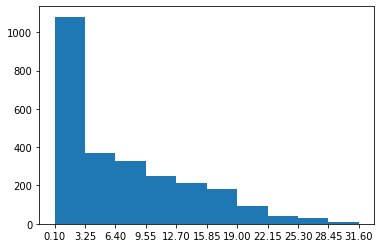

In [103]:
n, bins, _ = plt.hist(df_one_face_2012['percentage'], bins=10)
plt.xticks(bins)
plt.show()

In [21]:
known_image = face_recognition.load_image_file("/Users/tonleon/Desktop/4184.jpg")
keira_encoding = face_recognition.face_encodings(known_image)[0]
known_face_name = "Keira Knightley"


for i, image in enumerate(df_one_face_2012['frame_num']):
    unknown_image = face_recognition.load_image_file('/Users/tonleon/Documents/GitHub/Diploma/Films/2012_frames/'+image)
    unknown_encoding = face_recognition.face_encodings(unknown_image)
    if len(unknown_encoding) != 0:
        unknown_encoding = unknown_encoding[0]
        results = face_recognition.compare_faces([keira_encoding], unknown_encoding)
        df_one_face_2012.at[i, 'actor'] = known_face_name 

NameError: name 'df_one_face_2012' is not defined

In [122]:
df_one_face_2012.sort_values(by='frame_num')

,frame_num,num_of_faces,percentage,actor
909,1006_frame.jpg,1,[1.3150243771525696],None
255,100_frame.jpg,1,[3.8645614348973476],None
1055,1019_frame.jpg,1,[16.10904862011898],None
2343,101_frame.jpg,1,[3.6528454920904716],None
3770,1020_frame.jpg,1,[16.661634685631643],None
1730,1021_frame.jpg,1,[2.551214384756452],None
6255,1029_frame.jpg,1,[5.012598589554353],None
6558,1030_frame.jpg,1,[7.01420882348556],None
4761,1031_frame.jpg,1,[10.29226491330083],None
2446,1032_frame.jpg,1,[9.603442620506627],None


## Фильм 1967

In [27]:
film_path_1967_1 = '/Users/tonleon/Desktop/Анна Каренина.1967.1_серия.mkv'
film_path_1967_2 = '/Users/tonleon/Desktop/Анна Каренина.1967.2_серия.mkv'


In [47]:
extract_every_k_second_frame(film_path_1967_1, '1967_frames', 1)

In [48]:
extract_every_k_second_frame(film_path_1967_2, '1967_frames', 1, 4529)

In [8]:
data_1967 = create_df_with_frames_info('1967_frames')

In [9]:
data_1967.to_csv('/Users/tonleon/Documents/GitHub/Diploma/Films/Data/All_Frames_1967.csv', header=True)

In [10]:
df_one_face_1967 = one_face_frames(data_1967)

NameError: name 'one_face_frames' is not defined

In [95]:
df_one_face_1967['percentage'] = df_one_face_1967['percentage'].apply(lambda x: round(x[0], 1))

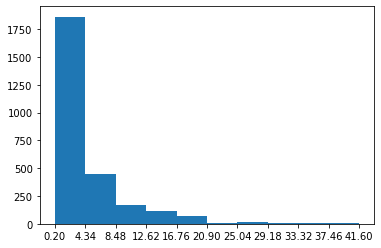

In [102]:
n, bins, _ = plt.hist(df_one_face_1967['percentage'], bins=10)
plt.xticks(bins)
plt.show()

## Фильм 1997 года

In [11]:
film_path_1997 = '/Users/tonleon/Desktop/Anna.Karenina.1997.720p.BluRay.x264-DNL.mkv'

In [12]:
extract_every_k_second_frame(film_path_1997, '1997_frames', 1)
data_1997 = create_df_with_frames_info('1997_frames')
data_1997.to_csv('/Users/tonleon/Documents/GitHub/Diploma/Films/Data/All_Frames_1997.csv', header=True)

In [14]:
df_one_face_1997 = one_face_frames(data_1997)

In [15]:
df_one_face_1997['percentage'] = df_one_face_1997['percentage'].apply(lambda x: round(x[0], 1))

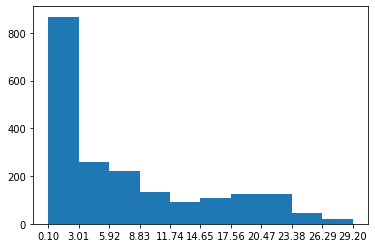

In [17]:
n, bins, _ = plt.hist(df_one_face_1997['percentage'], bins=10)
plt.xticks(bins)
plt.show()